In [63]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, Input, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import random as rn

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [64]:
train_data_dir = "./dataset/Plants/train"
val_data_dir = "./dataset/Plants/val"
test_data_dir = "./dataset/Plants/test"
img_size = (224, 224)
batch_size = 32
epoch = 60
num_classes = 6

In [65]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    )

val_data_generator = ImageDataGenerator(rescale=1./255)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [66]:
train_dataset = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode = 'rgb'
)
val_dataset = val_data_generator.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode = 'rgb'
)
test_dataset = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode = 'rgb'
)

Found 2856 images belonging to 6 classes.
Found 746 images belonging to 6 classes.
Found 164 images belonging to 6 classes.


In [67]:
def show_image_samples(gen):
    # Ensure the generator has class_indices attribute
    if hasattr(gen, 'class_indices'):
        test_dict = gen.class_indices
        classes = list(test_dict.keys())
    else:
        raise AttributeError("The provided generator does not have 'class_indices' attribute.")
    
    images, labels = next(gen)  # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    r = min(length, 25)  # show a maximum of 25 images

    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image, cmap='gray')
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, fontsize=16)
        plt.axis('off')
    
    plt.show()

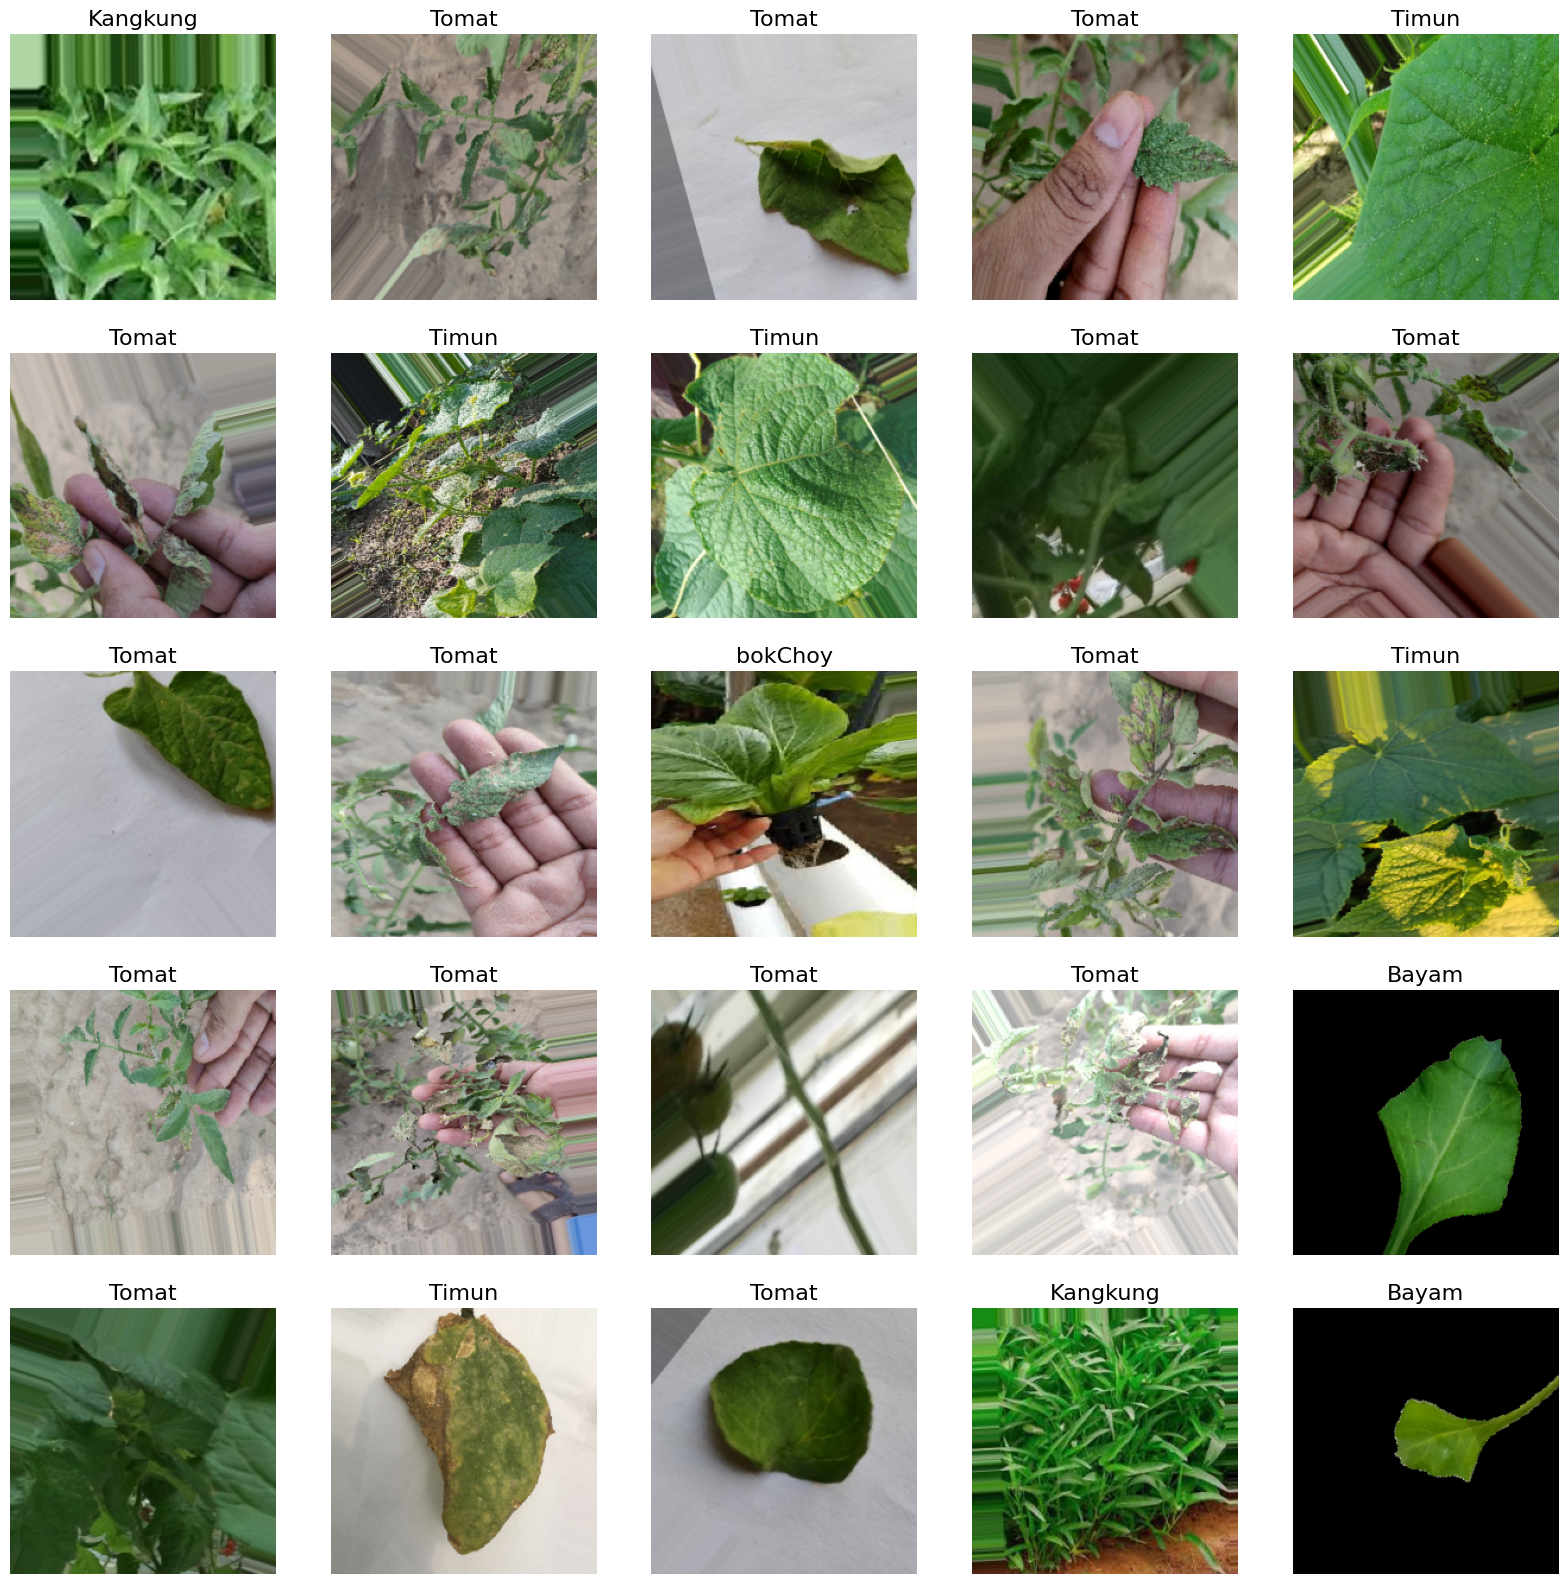

In [68]:
show_image_samples(train_dataset)

In [69]:
labels = np.unique(train_dataset.class_indices)
print(labels)

[{'Bayam': 0, 'Kangkung': 1, 'Selada': 2, 'Timun': 3, 'Tomat': 4, 'bokChoy': 5}]


In [70]:
classes_name = list(train_dataset.class_indices.keys())
classes_name

['Bayam', 'Kangkung', 'Selada', 'Timun', 'Tomat', 'bokChoy']

In [71]:
df_labels = pd.DataFrame(list(labels[0].keys()), columns=['Nama Tanaman'])
df_labels['Class'] = pd.DataFrame(list(labels[0].values()))
df_labels

Nama Tanaman  Class
0        Bayam      0
1     Kangkung      1
2       Selada      2
3        Timun      3
4        Tomat      4
5      bokChoy      5

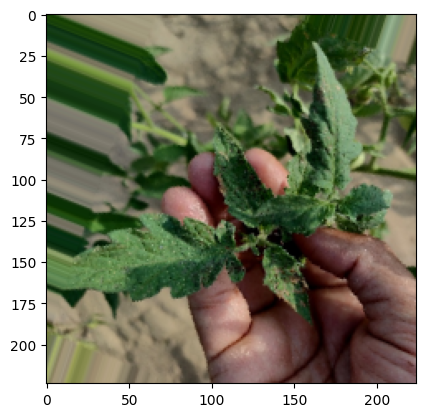

In [72]:
img, label = train_dataset[rn.randint(0, len(train_dataset))]
plt.imshow(img[0])

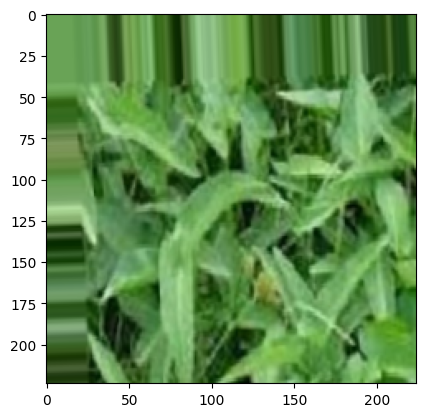

In [73]:
plt.imshow(train_dataset[0][0][0])

In [74]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [75]:
base_model.trainable = False

In [76]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(num_classes, activation='softmax')
])

model.build(input_shape=(None, 224, 224, 3))

In [77]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,261,862 (12.44 MB)

 Trainable params: 32,998 (128.90 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [78]:
model.compile(optimizer= Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [80]:
save_model = ModelCheckpoint('./model/plants/11ClassEpoch60dense64.keras', monitor='val_loss', verbose=1, save_best_only=True)

In [81]:
print(train_dataset.samples)
print(train_dataset.class_indices)
print(train_dataset.filenames)
print(len(train_dataset))

2856
{'Bayam': 0, 'Kangkung': 1, 'Selada': 2, 'Timun': 3, 'Tomat': 4, 'bokChoy': 5}
['Bayam\\-2020302-WA0078.png', 'Bayam\\-20230302-WA0066.png', 'Bayam\\-20230302-WA0078.png', 'Bayam\\-2230302-WA0066.png', 'Bayam\\1235975734.png', 'Bayam\\1245567977.png', 'Bayam\\17673772878.png', 'Bayam\\20230228_205516_fresh_leaf.png', 'Bayam\\20230228_205540_fresh_leaf.png', 'Bayam\\20230228_205552_fresh_leaf.png', 'Bayam\\20230228_205605(1).png', 'Bayam\\20230228_205605.png', 'Bayam\\20230228_205605_fresh_leaf.png', 'Bayam\\20230228_205611_fresh_leaf.png', 'Bayam\\20230228_205627_fresh_leaf.png', 'Bayam\\20230228_205635_fresh_leaf.png', 'Bayam\\20230228_205651_fresh_leaf.png', 'Bayam\\20230228_205658_fresh_leaf.png', 'Bayam\\20230228_205711_fresh_leaf.png', 'Bayam\\20230228_205717_fresh_leaf.png', 'Bayam\\20230228_205734_fresh_leaf.png', 'Bayam\\20230228_205738_.png', 'Bayam\\20230228_205801_fresh_leaf.png', 'Bayam\\20230228_205825_.png', 'Bayam\\20230228_205833_.png', 'Bayam\\20230228_205844_fres

In [82]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epoch, verbose=1, batch_size=batch_size, callbacks=[save_model,lr, early_stop], steps_per_epoch= train_dataset.samples // batch_size)

c:\Users\rihan\OneDrive\Documents\Machine Learning\Bangkit Capstone\Machine-Learning\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.5609 - loss: 1.3564
Epoch 1: val_loss improved from inf to 0.61890, saving model to ./model/plants/11ClassEpoch60dense64.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 77s 849ms/step - accuracy: 0.5622 - loss: 1.3520 - val_accuracy: 0.7949 - val_loss: 0.6189 - learning_rate: 0.0010
Epoch 2/60
 1/89 ━━━━━━━━━━━━━━━━━━━━ 27s 314ms/step - accuracy: 0.8750 - loss: 0.4935

C:\Users\rihan\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_loss improved from 0.61890 to 0.61650, saving model to ./model/plants/11ClassEpoch60dense64.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8750 - loss: 0.4935 - val_accuracy: 0.7976 - val_loss: 0.6165 - learning_rate: 0.0010
Epoch 3/60
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.7865 - loss: 0.5616
Epoch 3: val_loss improved from 0.61650 to 0.42273, saving model to ./model/plants/11ClassEpoch60dense64.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 76s 854ms/step - accuracy: 0.7868 - loss: 0.5609 - val_accuracy: 0.9035 - val_loss: 0.4227 - learning_rate: 0.0010
Epoch 4/60
 1/89 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - accuracy: 0.9375 - loss: 0.1962
Epoch 4: val_loss did not improve from 0.42273
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.9375 - loss: 0.1962 - val_accuracy: 0.9008 - val_loss: 0.4259 - learning_rate: 0.0010
Epoch 5/60
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8726 - loss: 0.3815
Epoch 5: val_loss improved from 0.42273 to 0.3

In [83]:
def lossAcc(data):
  loss, accuracy = model.evaluate(data)

  print(f'Loss : {loss}')
  print(f'Accuracy : {accuracy}')

In [85]:
print(lossAcc(train_dataset))
print(lossAcc(val_dataset))

90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 646ms/step - accuracy: 0.9812 - loss: 0.0712
Loss : 0.07194599509239197
Accuracy : 0.980042040348053
None
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 376ms/step - accuracy: 0.8225 - loss: 0.8245
Loss : 0.38837769627571106
Accuracy : 0.9155495762825012
None


In [86]:
def plot_history(history):
  plt.figure(figsize=(12, 6))
  plt.subplot(1,2,1)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  plt.subplot(1,2,2)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  
  plt.show()

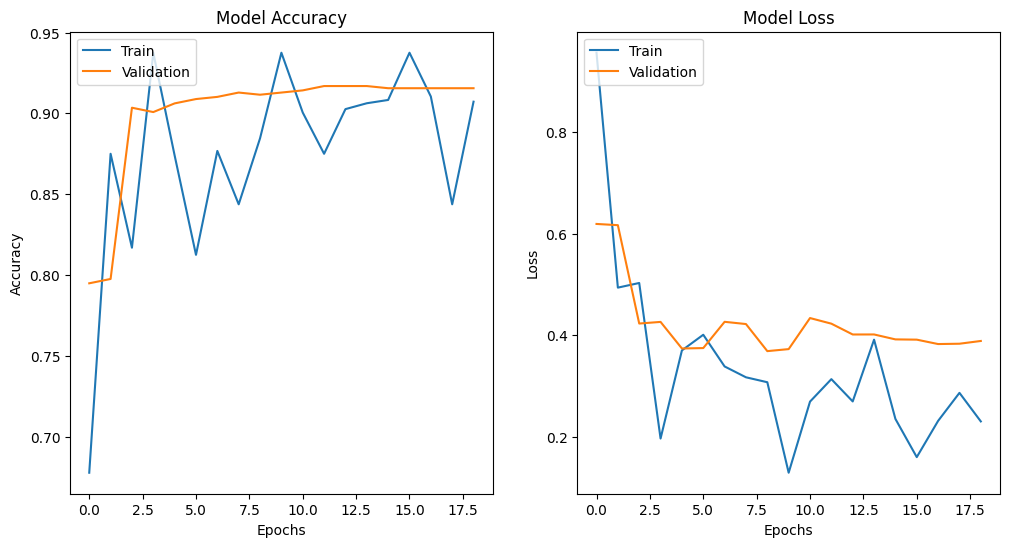

In [87]:
plot_history(history.history)